# The `svarlr` Module
##### Kyle Murphy 2020-02-21

This is a walkthrough of the svarlr package available here:

https://pypi.org/project/svarlr/

The svarlr python package contains functions to estimate structural vector autoregressions with long-run restriction. It includes functions for estimating multivariate vector autoregressions with long-run restrictions imposed, generating impulse response filters, series bootstrapping and generating minimum distance confidence intervals.

The package can be installed with:

`pip install svarlr`

Import the packages needed, in this case:

- numpy 
- pandas
- matplotlib
- svarlr
- pandas-datareader (to download FRED data)
- seaborn (better looking plots)

In [1]:
# This is the proper way to install a package within a jupyter notebook 
# environment.
import sys
!{sys.executable} -m pip install svarlr

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import svarlr
import pandas_datareader as pdr
import seaborn as sns

%matplotlib inline
sns.set()

/usr/local/lib/python3.7/site-packages/pandas_datareader/compat/__init__.py:7: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  from pandas.util.testing import assert_frame_equal


The data we are going to use is located here:

https://raw.githubusercontent.com/murphy-k/svarlr/master/Germany.csv

Total Factor Productivity and Employment Total Hour Growth. We an explore how technology shocks impact employment, and vice-versa.

We can read in the data with the pandas module.

In [3]:
series = pd.read_csv("https://raw.githubusercontent.com/murphy-k/svarlr/master/Germany.csv")

We can index the data by the year column, and then drop it. 

In [4]:
series.index = series.Year
series = series.drop(['Year'],axis=1)
series

,TFP,TotHrGrowth
Year,,
1951-01-01,6.894657,1.037311
1952-01-01,5.080555,0.634502
1953-01-01,4.542223,1.454624
1954-01-01,3.185142,1.806637
1955-01-01,5.412597,2.032252
...,...,...
2012-01-01,-0.346423,-0.127787
2013-01-01,-0.059366,-0.288752
2014-01-01,0.591983,1.158355


Let's define some variables before we begin model estimation. We need to specify the order of lag (we will use 1 in this example) as well as the number of periods for the Impulse Response Functions, and the maximum number of periods that we will show in the IRF graph.

In [5]:
p = 1       # order of VAR lag
nIR = 50    # number of periods for Impulse Response
nIRF = 5    # maximum periods shown in IRF graph

The function `varlr` takes a series that can be an array or dataframe (will automatically be transformed to an array) that is our data. The second parameter is the VAR order, and is set to 1 by default.

In [6]:
[b, Sig, B] = svarlr.varlr(series,p) # VAR of order 'p'

`varlr` returns three objects:
- b: An array that is the VAR coefficient vector [A0,A1,...,Ap].
- Sig: variance-covariance matrix of reduced form error.
- B: structural transform matrix computed with long-run restriction imposed. [Blanchard-Quah (1989)].

The `irflr` function takes three arguments:
- b: The above estimated VAR coefficients.
- B: The structural matrix for error.
- nIR: The number of periods of the IRF.

In [7]:
IRF = svarlr.irflr(b,B,nIR) # Impulse response (or MA coefficients)

`irflr` returns an array. 

$s-th$ column has $(s-1)$ period of IRF 

$[ t(11) t(21) ... t(n1) t(12)...]'$

$t(ij)$ stands for effect of $j$ shock on variable $i$.

`cor` takes the impulse response of VAR and returns an array of correlation coefficients.

In [8]:
corr = svarlr.cor(IRF) # Correlations
print(corr)

[[ 0.22531014 -0.05921974  0.74241692]]


In order to get the impulse response of TFP, we need to some all the coefficients of dTFP. Then we can transform the array into a dataframe.

In [9]:
IRF = np.vstack([(IRF[0,:].cumsum()),
                 (IRF[1,:].cumsum()),
                 (IRF[2,:].cumsum()),
                 (IRF[3,:].cumsum())])

We now have the impulse response functions, but we need to bootstrap the series to estalish confidence intervals.

First we can create objects to hold the various results from the loop we will implement to accompish the boostrapping.

In [10]:
Sim = 1000 # The number of bootstrap iterations

corr_b = []
IRF1 = []
IRF2 = []
IRF3 = []
IRF4 = []
srrsim = []

`bootstrap` takes three arguments:
- y: The series to bootstrap.
- p: The order of lags.
- k: The number of initial observation trimming.

And returns a bootstrapped series.

In [11]:
for i in range(1,Sim+1):
    series_b = svarlr.bootstrap(series,p,len(series)+30) # Pseudo Series generated
    b_b,Sig_b,B_b = svarlr.varlr(series_b, p)
    IRF_b = svarlr.irflr(b_b,B_b,nIR)
    ith_cor = svarlr.cor(IRF_b)
    IRF1.append(IRF_b[0,:].cumsum()[np.newaxis])
    IRF2.append(IRF_b[1,:].cumsum()[np.newaxis])
    IRF3.append(IRF_b[2,:].cumsum()[np.newaxis])
    IRF4.append(IRF_b[3,:].cumsum()[np.newaxis])

IRF1 = np.vstack(IRF1)
IRF2 = np.vstack(IRF2)
IRF3 = np.vstack(IRF3)
IRF4 = np.vstack(IRF4)

The `band` function calculates a minimum-distance interval and takes two arguments:

- mat: The array to calculate the intervals.
- ptg: Decimal representation of confidence interval percentage.

And returns the confidence intervals.

In [12]:
band1 = svarlr.band(IRF1,.90);
band2 = svarlr.band(IRF2,.90);
band3 = svarlr.band(IRF3,.90);
band4 = svarlr.band(IRF4,.90);

We can take all the above and put it together into a large plot with four subplots.

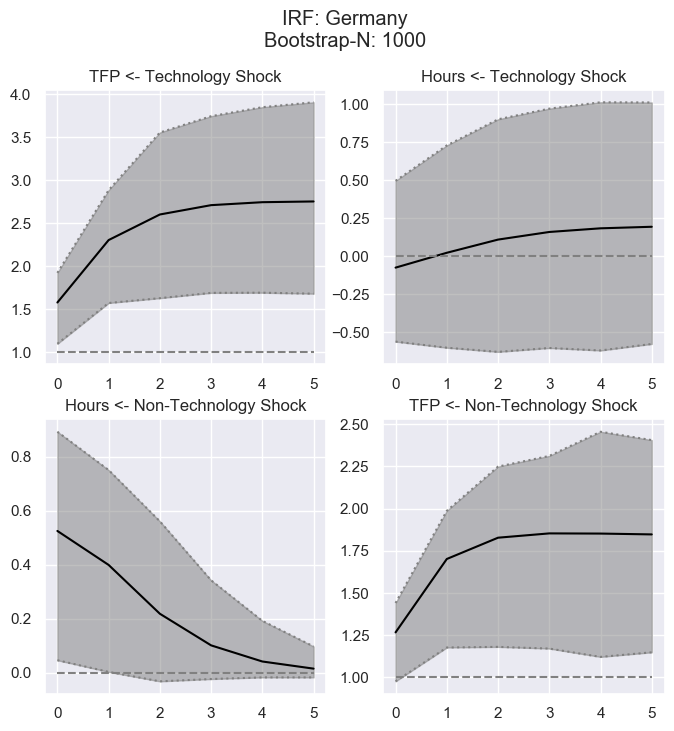

In [13]:
df_IRF = pd.DataFrame(IRF)

# First transpose the df. 
df_IRF = df_IRF.T
col_names = ['TFP <- Technology Shock', 'Hours <- Technology Shock','Hours <- Non-Technology Shock','TFP <- Non-Technology Shock']
df_IRF.columns = col_names

# Define graphic settings
t = nIRF+1
fig_size = (8, 8)
fig_dpi = 100 

# Build the plots
fig, axes = plt.subplots(nrows=2,ncols=2, figsize=fig_size, dpi=fig_dpi)
fig.suptitle("IRF: Germany\nBootstrap-N: {}".format(Sim))

# First Plot
df_IRF.iloc[:t,0].plot(ax=axes[0,0], color='black'); axes[0,0].set_title('TFP <- Technology Shock')
axes[0,0].plot(band1.T[:t,:], color='gray',linestyle='dotted')
axes[0,0].plot(np.ones([t,1]), color='gray',linestyle='dashed')
axes[0,0].fill_between(np.arange(0,t,1),band1[0,:t], band1[1,:t],color='gray',alpha=0.5)

# Second Plot
df_IRF.iloc[:t,1].plot(ax=axes[0,1], color='black'); axes[0,1].set_title('Hours <- Technology Shock')
axes[0,1].plot(band2.T[:t,:], color='gray',linestyle='dotted')
axes[0,1].plot(np.zeros([t,1]), color='gray',linestyle='dashed')
axes[0,1].fill_between(np.arange(0,t,1),band2[0,:t], band2[1,:t],color='gray',alpha=0.5)
               
# Third Plot
df_IRF.iloc[:t,2].plot(ax=axes[1,0], color='black'); axes[1,0].set_title('Hours <- Non-Technology Shock')
axes[1,0].plot(band3.T[:t,:], color='gray',linestyle='dotted')
axes[1,0].plot(np.zeros([t,1]), color='gray',linestyle='dashed')
axes[1,0].fill_between(np.arange(0,t,1),band3[0,:t], band3[1,:t],color='gray',alpha=0.5)

# Fouth Plot
df_IRF.iloc[:t,3].plot(ax=axes[1,1], color='black'); axes[1,1].set_title('TFP <- Non-Technology Shock')
axes[1,1].plot(band4.T[:t,:],color='gray',linestyle='dotted')
axes[1,1].plot(np.ones([t,1]),color='gray',linestyle='dashed')
axes[1,1].fill_between(np.arange(0,t,1),band4[0,:t], band4[1,:t],color='gray',alpha=0.5)

plt.show()

We have now captured the linear interdependencies among multiple time series, in this case total factor productivity and total employment hour growth for Germany from 1951-2016. 

Thank you.